To tutaj sprawdza proste parametry żeby sprawdzić czy skrypt działa dobrze.
Bardziej skomplikowane siatki wrzucać na kaggla po dopasowaniu i dobraniu danych -
trzeba zmienić nazwe pliku tutaj niżej

In [1]:
TITLE = 'bagging.1'
DATA_PATH = '../dataset.reduced.csv'
CROSS_VAL_N = 3
GRID = {
    'regressor__n_estimators': [10],
    'regressor__max_samples': [0.5],
    'regressor__max_features': [0.5],
    'regressor__bootstrap': [True],
    'regressor__bootstrap_features': [True],
    'regressor__oob_score': [True],
    'regressor__warm_start': [False]
}

In [2]:
"""Wczytanie"""
from pandas import read_csv
df = read_csv(DATA_PATH, index_col=0, low_memory=False).drop(columns=['free_month', 'free_year'], axis=1)
X = df.drop('price', axis=1)
y = df['price']
del df

In [3]:
"""Podział"""
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X, y

In [4]:
"""Preproes"""
cat = train.select_dtypes(include='object').columns
fill_med=['year', 'rooms', 'floor']
fill_0=['area_outside', 'rent']
passthrough = [c for c in train.columns if c not in [*fill_med, *fill_0, *cat]]
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
pre = ColumnTransformer(transformers=[
    ('fill_med', Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))]), fill_med),
    ('fill_0', Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value=0))]), fill_0),
    ('1hot', Pipeline(steps=[('encoder', OneHotEncoder())]), cat),
    ('passthrough', make_pipeline('passthrough'), passthrough)
])

In [5]:
"""Model"""
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', pre),
    ('regressor', BaggingRegressor(estimator=DecisionTreeRegressor()))
])

In [6]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(pipeline, GRID, cv=CROSS_VAL_N, scoring='neg_mean_absolute_error')
search.fit(train, y_train)

/home/adam/.local/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:1261: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/adam/.local/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:1261: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/adam/.local/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:1261: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/home/adam/.local/lib/python3.10/site-packages/sklearn/ensemble/_bagging.py:1261: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('fill_med',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['year',
                                                                          'rooms',
                                                                          'floor']),
                                                                        ('fill_0',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value=0,
                                                                                                        strategy='constant'))]),
                                                                         ['area_outside',
                                                                          'rent']),
                                                                        ('1hot',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEnc...
                                                                          'utility_space'])])),
                                       ('regressor',
                                        BaggingRegressor(estimator=DecisionTreeRegressor()))]),
             param_grid={'regressor__bootstrap': [True],
                         'regressor__bootstrap_features': [True],
                         'regressor__max_features': [0.5],
                         'regressor__max_samples': [0.5],
                         'regressor__n_estimators': [10],
                         'regressor__oob_score': [True],
                         'regressor__warm_start': [False]},
             scoring='neg_mean_absolute_error')

In [8]:
model = search.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('fill_med',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['year', 'rooms', 'floor']),
                                                 ('fill_0',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'))]),
                                                  ['area_outside', 'rent']),
                                                 ('1hot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['category',...
                                                   'utility_closed',
                                                   'utility_connectivity',
                                                   'utility_entryphone',
                                                   'utility_equipment',
                                                   'utility_furniture',
                                                   'utility_garden',
                                                   'utility_lift',
                                                   'utility_media',
                                                   'utility_pool',
                                                   'utility_rollers',
                                                   'utility_security',
                                                   'utility_space'])])),
                ('regressor',
                 BaggingRegressor(bootstrap_features=True,
                                  estimator=DecisionTreeRegressor(),
                                  max_features=0.5, max_samples=0.5,
                                  oob_score=True))])

In [42]:
from pandas import DataFrame, to_numeric
cv_scores = DataFrame(search.cv_results_)
cv_scores.set_index('rank_test_score', inplace=True)
cv_scores = cv_scores.apply(to_numeric, errors='coerce')
cv_scores.to_csv(f'{TITLE}.csv')
cv_scores

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__bootstrap,param_regressor__bootstrap_features,param_regressor__max_features,param_regressor__max_samples,param_regressor__n_estimators,param_regressor__oob_score,param_regressor__warm_start,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,,
1,26.340993,3.45418,4.547992,0.892017,True,True,0.5,0.5,10,True,False,NaN,-131013.484454,-132935.902534,-143546.46484,-135831.950609,5511.15355


In [51]:
def scatter_3d(df, 
    x_col, x_title, 
    y_col, y_title, 
    z_col, z_title, 
    size_col, size_title, 
    color_col, color_title, color_scale=None, 
    scatter=0.01
):

    from plotly.graph_objects import Figure, Scatter3d
    from numpy import random, log, mean

    fig = Figure(data=[Scatter3d(
        x=df[x_col] + mean(df[x_col]) * random.normal(0, scatter, size=len(df)),
        y=df[y_col] + mean(df[y_col]) * random.normal(0, scatter, size=len(df)),
        z=df[z_col] + mean(df[z_col]) * random.normal(0, scatter, size=len(df)),
        mode='markers',
        marker=dict(
            size=df[size_col],
            sizemode='diameter',
            sizeref=2.*max(df[size_col])/(40),
            opacity=0.8,
            color=df[color_col],
            colorscale='thermal',
            colorbar=dict(title=color_title),
            cmin=color_scale[0] if color_scale else None,
            cmax=color_scale[1] if color_scale else None
        ),
        text=
            x_title + '=' + df[x_col].astype(str) + '; ' + 
            y_title + '=' + df[y_col].astype(str) + '; ' + 
            z_title + '=' + df[z_col].astype(str) + '; ' +
            (size_title + '='+ df[size_col].astype(str) + '; ') if size_title else '' + 
            (color_title + '='+ round(df[color_col],3).astype(str)) if color_col else '',
        hoverinfo='text'
    )])

    fig.update_layout(
        title="Parametry i wyniki walidacji krzyżowej",
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            xaxis_title=x_title,
            yaxis_title=y_title,
            zaxis_title=z_title
        )
    )
    
    return fig

In [53]:
scatter_3d(cv_scores, 
    'param_regressor__n_estimators', 'liczba drzew',
    'param_regressor__max_features', 'liczba cech',
    'mean_test_score', 'średni wynik walidacji',
    'param_regressor__max_samples', 'rozmiar próbki',
    'mean_test_score', ''
)

In [55]:
"""Predykcje"""
from pandas import Series
pred_train = Series(model.predict(train))
pred_test = Series(model.predict(test))

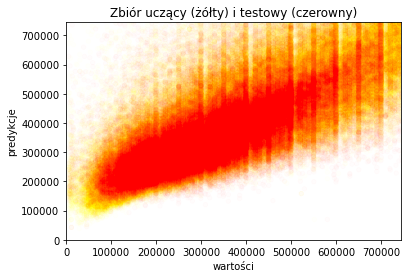

In [56]:
"""Wykres predykcji"""
from pandas import DataFrame, Series
DataFrame({ 'y': [*y_train, *y_test], 'p': [*pred_train, *pred_test]}).plot(
    kind='scatter', 
    title="Zbiór uczący (żółty) i testowy (czerowny)",
    x='y', xlabel='wartości', xlim=(0, pred_test.quantile(.90)),
    y='p', ylabel='predykcje', ylim=(0, pred_test.quantile(.90)),
    c=Series(([0] * len(pred_train) + [1] * len(pred_test))).map({0: 'yellow', 1: 'red'}), 
    alpha=.01
);

In [57]:
"""Punktacja"""
from sklearn import metrics
from numpy import sqrt
from pandas import DataFrame
cv_scores = DataFrame({
    'R2': [metrics.r2_score(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'MSE': [metrics.mean_squared_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'RMSE': [sqrt(metrics.mean_squared_error(y_test, pred_test)), metrics.r2_score(y_train, pred_train)],
    'MAE': [metrics.mean_absolute_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)],
    'MAPE': [metrics.mean_absolute_percentage_error(y_test, pred_test), metrics.r2_score(y_train, pred_train)]
},  index = ['test', 'train'])

cv_scores

,R2,MSE,RMSE,MAE,MAPE
test,0.013840,6.087669e+12,2.467320e+06,130511.481665,0.367914
train,0.383028,3.830281e-01,3.830281e-01,0.383028,0.383028


In [58]:
"""Migawka modelu"""
import pickle
with open(f'{TITLE}.pkl', 'wb') as file:
    pickle.dump(pipeline, file)